Analyzing TRAP data

In [1]:
import os
import numpy as np
import pandas as pd
import shutil
from read_roi import read_roi_file
import tifffile
import matplotlib.pyplot as plt
import create_mask_for_region
from datetime import datetime
from contour_visualization import *

#import shap
# read heatmap plots
#import Heatmap_plots as hmp
import seaborn as sns
import pickle
import tifffile as tiff

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list

In [2]:
# set figure key
figure_key = 'Figure6'

In [3]:
# set paths
result_paths = r"\\10.158.246.229\DataCommon\SmartSPIM2\Ken\OPTRAP"
rootpath = r"\\10.159.50.7\LabCommon\Ken\data\OPTRAP"
metapath = os.path.join(rootpath,"meta")
analysis_resultpath = os.path.join(rootpath,"result")
analysis_figurepath = os.path.join(r"G:\My Drive\Opioid_whole_brain_manuscript","figure",figure_key)
for path in [analysis_resultpath,analysis_figurepath]:
    if not os.path.exists(path):
        os.mkdir(path)

# load meta info of the files
metadf = pd.read_csv(os.path.join(metapath,"OPTRAP_meta.csv"),index_col= False)

# load brain atlas to register
atlas_df = pd.read_csv(r"\\10.159.50.7\Analysis2\Ken\ClearMap\clearmap_ressources_mouse_brain\ClearMap_ressources\Regions_annotations\atlas_info_KimRef_FPbasedLabel_v4.0_brain_with_size_with_curated_with_cleaned_acronyms.csv",index_col = False)
metacolumns = ['id','acronym','parent_acronym','parent_id','structure_order']
contour_img = tifffile.imread(r"\\10.159.50.7\Analysis2\Ken\ClearMap\clearmap_ressources_mouse_brain\ClearMap_ressources\Regions_annotations\Kim_ref_adult_FP-label_v2.9_contour_map.tif")
# retrieve list of files
fnames =  [f for f in metadf.fname.values if 'DONE' in f]
# get all the leaf nodes
leafnodes = np.setdiff1d(atlas_df.acronym.unique(),atlas_df.parent_acronym.unique())

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from adjustText import adjust_text

# Set matplotlib parameters for white text on transparent background
plt.rcParams.update({
    'figure.facecolor': 'none',  # Transparent figure background
    'axes.facecolor': 'none',    # Transparent axes background
    'axes.edgecolor': 'black',   # White axes edge color
    'axes.labelcolor': 'black',  # White axis labels
    'xtick.color': 'black',      # White tick labels
    'ytick.color': 'black',      # White tick labels
    'legend.facecolor': 'none',  # Transparent legend background
    'legend.edgecolor': 'none',  # Transparent legend edgecolor
    'text.color': 'black',       # White text color
    'font.family':'Arial',
    'pdf.fonttype':42,
    'ps.fonttype':42,
   
})
#important for text to be detected when importing saved figures into illustrator


In [5]:
#Conditions = metadf.Condition.unique()
# Use only morphine related groups
Conditions = ['AcM-AcM','Sal-AcM', 'AcM-ChM','AcM-WDM', ]

print(Conditions)
#Condition_figure_name = ['Saline','Acute','Chronic 1 day','W.D. 1 day','Chronic 21 days','W.D. 21 days'] # changed this to betterones
Condition_figure_name = ['$Acute^{TRAP}$','$Saline^{TRAP}$','$Chronic^{TRAP}$','$Early WD^{TRAP}$',] 
#display_Conditions = ['Acute','Acute-Acute','Acute-Chronic','Acute-W.D.']

Condition_color = ['lime','gray','orange','cyan',]
# subset the meta dataframe
metadf = metadf[metadf.Condition.isin(Conditions)]

# set channels for TRAP experiment
channels = ['Ex_561_Ch1_stitched','Ex_639_Ch2_stitched','overlap']
channel_names = ['TRAP','cFos','double']

# Load the acronyms for plotting
with open(os.path.join(analysis_resultpath,f'curated_acronym.pickle'), 'rb') as handle:
    curated_acronyms = pickle.load(handle)

with open(os.path.join(analysis_resultpath,f'ancestor_curated_acronym.pickle'), 'rb') as handle:
    ancestor_curated_acronyms = pickle.load(handle,)


plotting_variables = ['Ex_561_Ch1_stitched_newcounts','Ex_561_Ch1_stitched_density',
       'Ex_639_Ch2_stitched_newcounts', 'Ex_639_Ch2_stitched_density',
       'overlap_newcounts', 'overlap_density',
       'overlap_over_Ex_561_Ch1_stitched', 'overlap_over_Ex_639_Ch2_stitched','F1_Score']

['AcM-AcM', 'Sal-AcM', 'AcM-ChM', 'AcM-WDM']


remove HB and CBL from the list of ancestores

In [6]:
# Update the ancestor curated acronyms so it matches the tree devisions
unique_ancestor_curated_acronyms = ['Isocortex','OLF','HPF','CTXsp','STR','PAL','TH','HY','MB',]


remove CBL and MB subtree from the atlas file and the merge_df

In [7]:
ancestor_colors = ['#32FF00','#92278F','#F7941D','#00AEEF','#BE1E2D','#73E0FF','#00A79D','#2B3990','#637300']
root_node_color_dict = {}
for cidx,node_label in enumerate(['CTXsp', 'HPF', 'HY', 'Isocortex', 'MB', 'OLF', 'PAL', 'STR', 'TH']):
    root_node_color_dict[node_label] = ancestor_colors[cidx]

# update the ancestor_acronym in atlas_df
for ancestor_acronym in ['CTXsp', 'HPF', 'HY', 'Isocortex', 'MB', 'OLF', 'PAL', 'STR', 'TH']:
    print(ancestor_acronym)
    sub_tree = create_mask_for_region.get_subregions(atlas_df,atlas_df.loc[atlas_df.acronym == ancestor_acronym,'id'].values[0],return_original = True)
    atlas_df.loc[atlas_df.acronym.isin(sub_tree['acronym']),'ancestor_default_acronym'] = ancestor_acronym

CTXsp
HPF
HY
Isocortex
MB
OLF
PAL
STR
TH


# Preparation

## Prepare by region data

In [8]:
# all the by region data are stored in one master dataframe
total_df = pd.read_csv(os.path.join(analysis_resultpath,'total_long_merge_Annotated_counts_with_leaf_with_density.csv'),index_col = False)
total_df = total_df[total_df.Condition.isin(Conditions)]


In [9]:
# remove CBL and MB subtree from the data. These regions had bad registration quality and low interest
remove_ancestor_ids = atlas_df[(atlas_df.acronym == 'HB') | (atlas_df.acronym == 'CBL')]['id'].values
remove_df = pd.concat([create_mask_for_region.get_subregions(atlas_df,idx,return_original = True) for idx in remove_ancestor_ids],axis = 0)
sub_atlas_df = atlas_df.set_index(['id']).drop(remove_df['id'].values)
total_df = total_df[total_df.acronym.isin(sub_atlas_df.acronym.unique())]


### clean experiment variables for the GLM study

In [10]:
# load meta info of the files
metadf['age'] = [(datetime.strptime( pday, '%m/%d/%Y') - datetime.strptime( dob, '%m/%d/%Y')).days for pday,dob in metadf.loc[:,['Date_Perfusion','DOB']].values]
atlasmeta = total_df.reset_index().loc[total_df.reset_index().ID =='SM1',['id','parent_id','acronym','name','parent_acronym']]

# change categorical values to dummy chategories dtypes
sex_category = pd.CategoricalDtype(categories=['F', 'M'], ordered=False)
condition_category = pd.CategoricalDtype(categories=Conditions, ordered=True)
batch_category = pd.CategoricalDtype(categories=[1,2,], ordered=False)

total_df['Sex']             = total_df['Sex'].astype(sex_category)
total_df['Condition']       = total_df['Condition'].astype(condition_category)

total_df['Staining_Batch']  = total_df['Staining_Batch'].astype(batch_category)

# create dummy cats
condition_dummies           = pd.get_dummies(total_df['Condition'])
sex_dummies                 = pd.get_dummies(total_df['Sex']).loc[:,['F']].rename(columns = {'F':'Sex_d'}) # female 1
batch_dummies = pd.get_dummies(total_df['Staining_Batch'])
batch_dummies.columns = [f'Batch_{c}_d' for c in range(2)]

total_df                    = pd.concat([total_df,condition_dummies,sex_dummies,batch_dummies],axis =1)

## Run GLM

In [11]:
pannel_key = 'D'

In [272]:
# scale the metacolumns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
# First test if there is a difference in the average decay length between the 5 types.

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
from scipy.stats import chi2
def chi2_model_comparison(model1,model2):
    # Get the log-likelihoods of the models
    ll_null = model1.llf  # log-likelihood of the full model
    ll_restricted = model2.llf  # log-likelihood of the restricted model

    # Calculate the difference in log-likelihoods
    ll_diff = -2 * (ll_restricted - ll_null)

    # Degrees of freedom is the difference in the number of parameters
    df = model1.df_model - model2.df_model

    # Compute the p-value
    p_value = chi2.sf(ll_diff, df)
    return p_value



In [273]:
# setup the data that will go in the model
# the variable used will be the overlap density (c-Fos+ and TRAP+ cells)
sub_merge_df = total_df
plotting_variable = 'overlap_density'

In [274]:
# add a constant
sub_merge_df['constant'] = 1

In [275]:
# set some variable to define the model
continuous_vars = ['BW', 'Age']
metacolumns = list(Conditions[1:]) + ['Sex_d','BW','Age','constant'] # remove AcM-AcM, this will be the reference group


<Axes: >

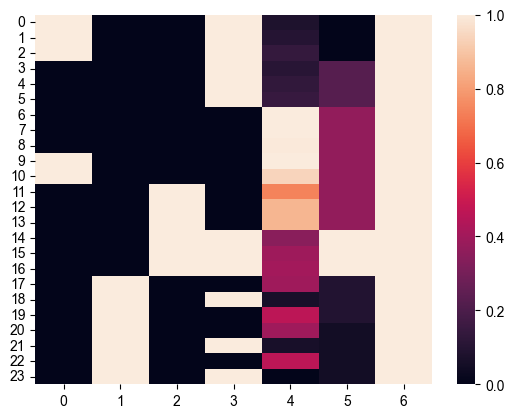

In [276]:

# visualize the variables

from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()

# get the variables, scale them and plot
exog = sub_merge_df.loc[(sub_merge_df.acronym == 'CH'),metacolumns]
exog[continuous_vars] = scaler.fit_transform(exog[continuous_vars])
variables = np.array(exog.astype('float'))
sns.heatmap(variables)

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


A24a (IL)-2


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1454: RuntimeWarning: divide by zero encountered in log
  ll_obs = endog * np.log(self.alpha * mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1454: RuntimeWarning: invalid value encountered in multiply
  ll_obs = endog * np.log(self.alpha * mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\

A32 (PrL)-2
A32 (PrL)-6b
LO-6b
MO-2/3


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuber

AID-6b
DLO-6a
DLO-6b
AIP-6b
AIV-6b
A29c (RSGc)-2


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


A25 (DP)-2
DTr


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1454: RuntimeWarning: divide by zero encountered in log
  ll_obs = endog * np.log(self.alpha * mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1454: RuntimeWarning: invalid value encountered in multiply
  ll_obs = endog * np.log(self.alpha * mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\

DLEnta
DLEntb
DLEnt4
DLEnt4/5
DLEnt5/6
DIEnt2a
DIEnt2b
DIEnt2/3
DIEnt4
DIEnt5/6
VIEnt4


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


6b


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self.

MCPO


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1454: RuntimeWarning: divide by zero encountered in log
  ll_obs = endog * np.log(self.alpha * mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1454: RuntimeWarning: invalid value encountered in multiply
  ll_obs = endog * np.log(self.alpha * mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: Perfec

Pi


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


DA14
Stg


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1454: RuntimeWarning: divide by zero encountered in log
  ll_obs = endog * np.log(self.alpha * mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1454: RuntimeWarning: invalid value encountered in multiply
  ll_obs = endog * np.log(self.alpha * mu)


MRe


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


TuLH
PeFLH


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Com
ReIC
Me5
SCO


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self.

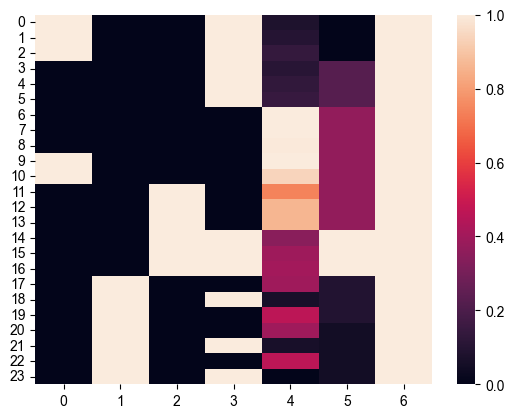

In [ ]:
# Predefine the link function
family = sm.families.NegativeBinomial()
plotting_variable = 'overlap_density' # use the overlap density as the variable to plot
for idx,acronym in enumerate(sub_merge_df.acronym.unique()):
    # don't run test if not enough subjects which seems to happen
    exog = sub_merge_df.loc[(sub_merge_df.acronym == acronym),metacolumns]
    exog[continuous_vars] = scaler.fit_transform(exog[continuous_vars])
    endog = sub_merge_df.loc[(sub_merge_df.acronym == acronym),plotting_variable]
    if idx == 0:
        sns.heatmap(np.array(exog.astype('float')))
        
    
    try:
        # run multiple GLM fits and comparison while dropping one of the variables

        glmfit = sm.GLM(endog, np.asarray(exog.astype('float64')),family=family,).fit()
        tglmfit = sm.GLM(endog, exog.astype('float64').drop(columns = Conditions[1:]),family=family,).fit() # Drop the conditions

        pvalue = chi2_model_comparison(glmfit,tglmfit) # calculate the pvalue from the chi2 likelihood test of the two models
        tdf = pd.DataFrame([pvalue],columns = ['Condition'])
        tdf['acronym'] = acronym
    except:
        # if doesn't run, save a nan
        # tdf = pd.DataFrame({'F':np.nan,'PR(>F)':np.nan,'acronym':acronym},index = [0])
        print(acronym)
        #tdf = pd.DataFrame(np.nan * np.zeros((1,len(metacolumns))),columns = metacolumns) # put pvalue of 1 with empty
        tdf = pd.DataFrame([np.nan],columns = ['Condition']) # put pvalue of 1 with empty
        tdf['acronym'] = acronym
        #print(acronym, " did not have enough subjects")

    if idx == 0:
        glm_stat_df = tdf
    else:
        glm_stat_df = pd.concat([glm_stat_df,tdf],axis=  0,).reset_index(drop = True)


In [278]:
# Write the glm stat data frame
glm_stat_df = pd.merge(create_mask_for_region.get_subregions(atlasmeta, 8, return_original=True),glm_stat_df,left_on = 'acronym',right_on = 'acronym').\
    rename(columns = {'name':'Name','Condition':'pvalue'})
glm_stat_df.to_csv(os.path.join(analysis_resultpath,f'{figure_key}_{pannel_key}_glm_stat_df_no_batch.csv'),index = False)
print(f'{figure_key}_{pannel_key}_glm_stat_df_no_batch.csv')

Figure6_D_glm_stat_df_no_batch.csv


### Run TreeBH to correct for multiple comparison

Run TreeFDR for the GLM test results with a p=0.01 threshold. This will happen on a separate R script (Opioid_Figure 6_TreeBH.R)

In [12]:
# read the results from the treeFDR f
TreeFDRF_df = pd.read_csv(os.path.join(analysis_resultpath,\
    f'TreeFDRF_pvalue_{figure_key}_{pannel_key}_glm_stat_df_no_batch.csv'),index_col = False)

In [13]:
# get the rejected acronyms
rejected_acronyms = TreeFDRF_df[(TreeFDRF_df.acronym.isin(curated_acronyms)) & (TreeFDRF_df.rejected == True)].acronym.values 
print(len(rejected_acronyms)," rejected acronyms")
print(rejected_acronyms)

111  rejected acronyms
['FrA' 'M1' 'M2' 'S1' 'S2' 'DI' 'GI' 'AuD' 'Au1' 'AuV' 'V2L' 'V2M' 'V1'
 'A24 (Cg)' 'A32 (PrL)' 'O' 'AI' 'A29-30 (RS)' 'PtA' 'TeA ' 'PRh' 'TT'
 'A25 (DP)' 'PIR' 'LOT' 'CO' 'PMCo' 'Apir' 'CA1' 'CA2' 'CA3' 'DG' 'IG'
 'DLEnt' 'DIEnt' 'VIEnt' 'MEnt' 'CEnt' 'PaS' 'Post' 'DS' 'VeS' 'STr' 'Cl'
 'La' 'CPre' 'CPr' 'CPi' 'CPc' 'IPAC' 'Tu' 'LS' 'SFi ' 'SHi ' 'SHy ' 'EP'
 'VeP' 'SI' 'MSC' 'TS' 'ST' 'BAC' 'Eth' 'VL' 'VA' 'VP' 'LP' 'Po' 'AV' 'AM'
 'IAM' 'PoMn' 'MD' 'Sub' 'Xi' 'ANS' 'RE' 'Rh' 'CM' 'PC' 'ASO' 'PVH' 'PaV'
 'Arc' 'AVPe' 'MnPO' 'MPA' 'VOLT' 'PDPO' 'PS' 'SCh' 'SFO' 'MBO' 'RCh'
 'Sag' 'VTA' 'Lth' 'Dk' 'APT' 'PCom' 'PPT' 'MA3' '3PC' '4Sh' 'Pa4' 'ATg'
 'SNC' 'IF' 'IP' 'CLi' 'DR']


In [14]:
# get a list of rejected regions from the TreeFDR result
sub_rejected_acronyms = TreeFDRF_df[(TreeFDRF_df.rejected == True) & (TreeFDRF_df.acronym.isin(curated_acronyms))].acronym

## Prepare heatmap data

Prepare heatmaps into a dictionary format

In [15]:
# the heatmaps generated in the TRAP experiment are stored in zarr format.
# load this in a dictionary format for plotting
import dask.array as da
heatmap_dict = {}
for channel in channels:

    #heatmap_da = da.from_array(heatmap_dict[channel], chunks=(1,256**3,))
    heatmap_dict[channel] = da.from_zarr(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\OpioidTRAP", f'{channel}_heatmap_array'), mode="r")
    
    heatmap_dict[f'normalized_{channel}'] = heatmap_dict[channel]/np.mean(heatmap_dict[channel],axis = 1)[:,None]

In [16]:
# the order of the heatmaps are stored in the fnamelist.npy file
fnamelist = np.load(os.path.join(analysis_resultpath,'fnamelist.npy'))

In [17]:
# read an annotated atlas file
atlas_img = tifffile.imread(r"\\10.159.50.7\Analysis2\Ken\LSMS\ClearMap\clearmap_ressources_mouse_brain\ClearMap_ressources\Regions_annotations\Kim_ref_adult_FP-label_v4.0.tif")

## run a linear regression analysis for the spatial data

In [199]:
# collect the variables
variable_df = total_df.loc[total_df.acronym == 'CH',['fname','Condition','BW','Age','Sex_d',]+Conditions]
variable_df = variable_df.set_index('fname')
variable_df = variable_df.loc[fnamelist,:]
# add constant
variable_df['constant'] = 1

In [200]:
variable_df = variable_df.drop(columns = ['BW','Sex_d']).join(metadf[['BW','Sex']])
variable_df['Sex']             = variable_df['Sex'].astype(sex_category)
sex_dummies                 = pd.get_dummies(variable_df['Sex']).loc[:,['F']].rename(columns = {'F':'Sex_d'}) # female 1
variable_df                    = pd.concat([variable_df,sex_dummies],axis =1)
variable_df = variable_df.drop(columns = 'Sex')

In [201]:
variables

array([[1.        , 0.        , 0.        , 1.        , 0.0794702 ,
        0.        , 1.        ],
       [1.        , 0.        , 0.        , 1.        , 0.09933775,
        0.        , 1.        ],
       [1.        , 0.        , 0.        , 1.        , 0.13907285,
        0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        , 0.10596026,
        0.22305764, 1.        ],
       [0.        , 0.        , 0.        , 1.        , 0.13245033,
        0.22305764, 1.        ],
       [0.        , 0.        , 0.        , 1.        , 0.14569536,
        0.22305764, 1.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.36591479, 1.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.36591479, 1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.99337748,
        0.36591479, 1.        ],
       [1.        , 0.        , 0.        , 0.        , 1.        ,
        0.36591479, 1. 

In [202]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler 

# Select only continuous variables for scaling
continuous_vars = ['BW', 'Age']  # Modify as needed
scaler = MinMaxScaler()
variable_df[continuous_vars] = scaler.fit_transform(variable_df[continuous_vars])

# sort the variable data frame
variable_df = variable_df.drop(columns = 'AcM-AcM') # drop AcM-AcM

variables = variable_df.drop(columns = 'Condition')

variables = np.array(variables.astype('float'))


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\sklearn\utils\_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\sklearn\utils\_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


<Axes: >

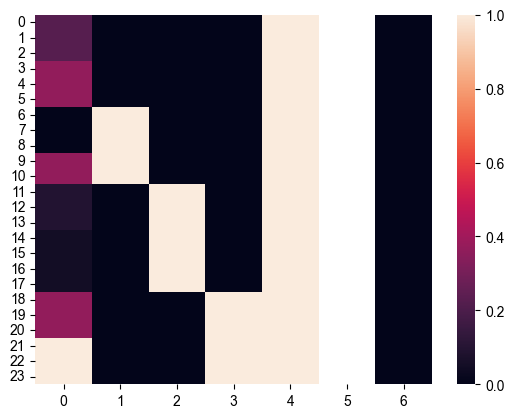

In [203]:
# visualize the variables
sns.heatmap(variables)

In [204]:
# remove the non brain regions
#brain_voxels = np.where(atlas_img.flatten()>0)[0]
# remove the non brain regions that have 0 values in the atlas_img
# remove the non brain regions that are not included in the analysis
# get the index of atlas_img values that are in atlas_df['id'].values
brain_voxels = np.where(np.isin(atlas_img.flatten(),atlas_df['id'].values))[0]

In [205]:
# subset the heatmap data to only include the brain voxels
brain_heatmap_da = heatmap_dict['overlap'][:,brain_voxels]
brain_heatmap_array = brain_heatmap_da.compute()

KeyboardInterrupt: 

In [ ]:
# run linear regression
import numpy as np
import pandas as pd
import statsmodels.api as sm
models = sm.OLS(brain_heatmap_array, variables,hasconst = None).fit()

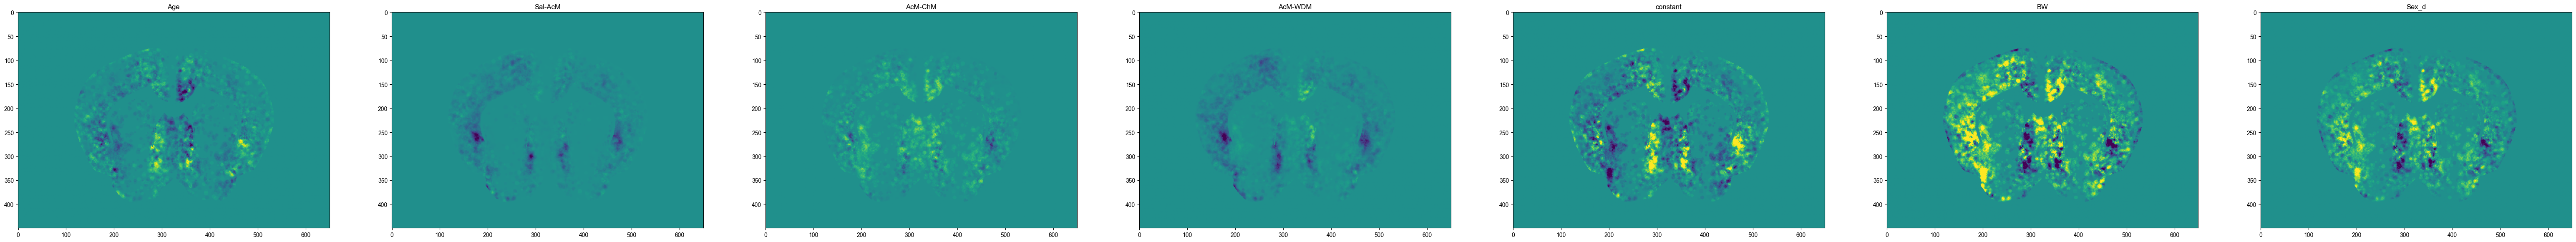

In [ ]:
fig,axs = plt.subplots(1,variable_df.shape[1]-1,figsize = (10*variable_df.shape[1]-1,10))
for variable_idx,variable_name in enumerate(variable_df.columns):
    if variable_idx == 0:
        continue
    temp_img = np.zeros_like(atlas_img.flatten(),dtype='float64')
    temp_img[brain_voxels] = models.params[variable_idx-1,:]
    axs[variable_idx-1].imshow(np.reshape(temp_img,atlas_img.shape).T[:,:,100].T,vmin = -5, vmax=  5)
    axs[variable_idx-1].set_title(variable_name)

In [ ]:
variable_df.columns

Index(['Condition', 'Age', 'Sal-AcM', 'AcM-ChM', 'AcM-WDM', 'constant', 'BW',
       'Sex_d'],
      dtype='object')

In [ ]:
# write the beta coefs
for variable_idx,variable_name in enumerate(variable_df.columns):
    if variable_idx == 0:
        continue
    temp_img = np.zeros_like(atlas_img.flatten(),dtype='float64')
    temp_img[brain_voxels] = models.params[variable_idx-1,:]
    np.save(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\OPTRAP\result",f'{channel}_{variable_name}_betas.npy'),np.reshape(temp_img,atlas_img.shape))
    tiff.imwrite(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\OPTRAP\result",f'{channel}_{variable_name}_betas.tif'),np.reshape(temp_img,atlas_img.shape).astype('float64'))

# Figure D

In [18]:
pannel_key = 'D'

In [19]:
# subset the merge dataframe
plotting_values = 'overlap_newcounts'
# sum the overlap_newcounts for the entire brain
tmerge_df = total_df.loc[(total_df.parent_acronym == 'grey'),['Condition','ID',plotting_values]].groupby(['Condition','ID']).sum().reset_index(drop = False)
tmerge_df= tmerge_df[tmerge_df[plotting_values]> 0] # remove the zero values that are the wrong combination of condition and ID

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_196504\2739833813.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmerge_df = total_df.loc[(total_df.parent_acronym == 'grey'),['Condition','ID',plotting_values]].groupby(['Condition','ID']).sum().reset_index(drop = False)


C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_196504\3128861791.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data = tmerge_df ,order = Conditions,\
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_196504\3128861791.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data = tmerge_df, order = Conditions,\


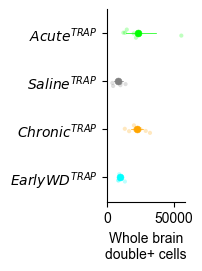

In [20]:
# collect whole brain c-Fos+ cell counts
fig,axs = plt.subplots(1,1,figsize = (1,2.5))
sns.stripplot(data = tmerge_df ,order = Conditions,\
    y = 'Condition',x = plotting_values,
            ax = axs,alpha = 0.25,size = 3,palette = Condition_color,)
sns.pointplot(data = tmerge_df, order = Conditions,\
    y = 'Condition',x = plotting_values,ax = axs,palette = Condition_color,
markers="o", markersize=5, linestyle="none",linewidth = 0.5)  

axs.set_yticks(range(len(Conditions)))
axs.set_yticklabels(Condition_figure_name,rotation = 0)
axs.set_xlim(0,)
axs.set_ylabel('')
axs.set_xlabel('Whole brain\ndouble+ cells')
sns.despine()
#acronym = acronym.replace('/','_')

fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_total_cells.png'),bbox_inches = 'tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_total_cells.pdf'),bbox_inches = 'tight',dpi = 216)

In [21]:
# The convert the rejected column to -1, 0, 1 (Not-rejected, Not-tested, Rejected)
# Merge the results from multiple formats
a = TreeFDRF_df.loc[TreeFDRF_df.acronym.isin(curated_acronyms),['acronym','rejected']].astype('str').replace('nan',0).replace('False',-1).replace('True',1).rename(columns = {'rejected':'TreeBH_F'})
heatmapdf = pd.concat([a.set_index('acronym')],axis = 1)

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_196504\51683262.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  a = TreeFDRF_df.loc[TreeFDRF_df.acronym.isin(curated_acronyms),['acronym','rejected']].astype('str').replace('nan',0).replace('False',-1).replace('True',1).rename(columns = {'rejected':'TreeBH_F'})


In [22]:
sub_curated_acronyms = heatmapdf.index

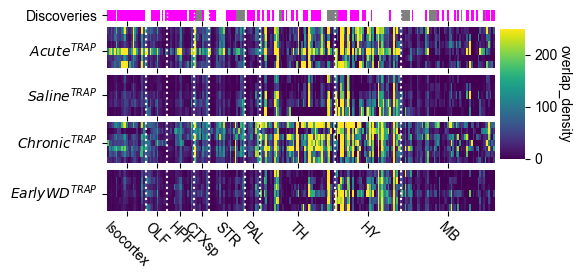

In [287]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

vmax = 250
vmin = 0
plotting_variable = 'overlap_density'
# Custom colormap for the first subplot
cmap = ListedColormap(['white', 'gray', 'magenta'])  # Colors for -1, 0, 1
bounds = [-1.5, -0.5, 0.5, 1.5]  # Boundaries for the values
norm = BoundaryNorm(bounds, cmap.N)

# read the result file
pivot_heatmap_df = pd.read_csv(os.path.join(analysis_resultpath,f'{plotting_variable}_pivoted_heatmap_df_without_zscore.csv'),index_col = 0)
total_df = pd.read_csv(os.path.join(analysis_resultpath,'total_long_merge_Annotated_counts_with_leaf_with_density.csv'),index_col = False)
# Create a subset version of the ancestor_sub_curated_acronyms
subset_ancestor_sub_curated_acronyms = [ancestor_curated_acronyms[idx] for idx,f in enumerate(curated_acronyms)]


# Create the merged figure
total_rows = len(Conditions) + 1  # Adding one row for the second figure

fig, ax = plt.subplots(total_rows, 1, figsize=(5, len(Conditions)*0.4 + 1), sharex=True, \
    gridspec_kw={"height_ratios": [0.25] + [1] * len(Conditions)})
# Plot the first subplot (top row)
theatmapdf = heatmapdf.loc[sub_curated_acronyms, ['TreeBH_F']]
subset_ancestor_sub_curated_acronyms = [ancestor_curated_acronyms[idx] for idx, f in enumerate(curated_acronyms) if f in theatmapdf.index]

__, indexes = np.unique(subset_ancestor_sub_curated_acronyms, return_index=True)
ytick_labels = [subset_ancestor_sub_curated_acronyms[index] for index in sorted(indexes)]
counts = [len(np.where(np.array(subset_ancestor_sub_curated_acronyms) == ylabel)[0]) for ylabel in ytick_labels]

borders = [0] + list(np.cumsum(counts))
x = np.array(borders)
yticks = (x[1:] + x[:-1]) / 2

sns.heatmap(data=theatmapdf.T, cbar=False, ax=ax[0], cmap=cmap, norm=norm)  # Applied custom colormap and norm
ax[0].set_xticks(yticks)
ax[0].set_xticklabels(ytick_labels, rotation=0)
ax[0].set_xlabel('')
[ax[0].axvline(border, color='white', lw=1, ls=':') for border in borders[1:-1]]
ax[0].set_yticks([0.5])
ax[0].set_yticklabels(['Discoveries'], rotation=0)



for idx,condition in enumerate(Conditions):
    axs = ax[idx+1]
    subjects = metadf[(metadf.Condition == condition) & (metadf.fname)].ID.values
    if idx == len(Conditions)-1:
        cbar_ax = fig.add_axes([ax[len(Conditions)].get_position().x1+0.01,ax[len(Conditions)].get_position().y0+0.2,0.05,0.5])
        sns.heatmap(data = pivot_heatmap_df.loc[sub_curated_acronyms,subjects].T,cbar_ax = cbar_ax
        ,ax = axs,vmin = vmin, vmax = vmax,cmap = 'viridis')
        cbar_ax.set_ylabel(plotting_variable, rotation=270, labelpad=10,fontsize = 10)
    else:
        sns.heatmap(data = pivot_heatmap_df.loc[sub_curated_acronyms,subjects].T,cbar = False
        ,ax = axs,vmin = vmin, vmax = vmax,cmap = 'viridis')
    axs.set_xticks(yticks)
    axs.set_xticklabels(ytick_labels,rotation = -45)
    axs.set_xlabel('')
    [axs.axvline(border,color = 'white',lw = 1.5,ls = ':') for border in borders[1:-1]]
    axs.set_yticks([pivot_heatmap_df.loc[sub_curated_acronyms,subjects].T.shape[0]//2+0.5])
    #axs.set_yticklabels([],rotation = 0) 
    axs.set_yticklabels([Condition_figure_name[idx]],rotation = 0)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_heatmap.png'),bbox_inches = 'tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_heatmap.pdf'),bbox_inches = 'tight',dpi = 216)


# Figure E-G

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_45484\1651470138.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data = tdata,x = 'Condition',y = plotting_variable,\
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_45484\1651470138.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data = tdata,x = 'Condition',y = plotting_variable,\
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_45484\1651470138.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels([Condition_figure_name[1]] + [Condition_figure_name[0]],rotation= -45)


Sal-AcM vs. AcM-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:5.937e-03 t=-3.579e+00


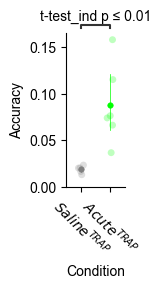

In [302]:
from statannotations.Annotator import Annotator
pannel_key = 'Edash'
pairs = [("AcM-AcM",'Sal-AcM'),]
sub_conditions = ['Sal-AcM',"AcM-AcM"]
plotting_variable = 'overlap_over_Ex_639_Ch2_stitched'

fig,axs = plt.subplots(1,1,figsize = (0.75,2))
tdata = total_df[(total_df.acronym.isin(rejected_acronyms))&(total_df.Condition.isin(['Sal-AcM',"AcM-AcM"]))
&(total_df.Ex_561_Ch1_stitched_newcounts>0)&(total_df.Ex_639_Ch2_stitched_newcounts>0)
    ]
tdata = tdata[['ID','Condition',plotting_variable]].groupby(['ID','Condition']).mean().reset_index()
sns.stripplot(data = tdata,x = 'Condition',y = plotting_variable,\
        order = sub_conditions,ax = axs,palette = ['gray','lime'],alpha = 0.25)
sns.pointplot(data = tdata,x = 'Condition',y = plotting_variable,\
        order = sub_conditions,ax = axs,palette = ['gray','lime'],
markers="o", markersize=4, linestyle="none",linewidth = 0.5)        
sns.despine()
axs.set_ylim(0,)
axs.set_ylabel('Accuracy')
axs.set_xticklabels([Condition_figure_name[1]] + [Condition_figure_name[0]],rotation= -45)

annotator = Annotator(axs, pairs, data=tdata, x='Condition', y=plotting_variable, order=sub_conditions)
annotator.configure(test='t-test_ind', text_format='simple', loc='outside',)
annotator.configure(comparisons_correction="BH", correction_format="replace")
annotator.apply_and_annotate()
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches = 'tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches = 'tight',dpi = 216)

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_45484\3301131291.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data = tdata,x = 'Condition',y = plotting_variable,\
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_45484\3301131291.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data = tdata,x = 'Condition',y = plotting_variable,\
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_45484\3301131291.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels([Condition_figure_name[1]] + [Condition_figure_name[0]],rotation= -45)


Sal-AcM vs. AcM-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:2.646e-01 t=-1.190e+00


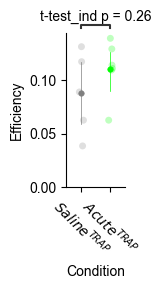

In [305]:
from statannotations.Annotator import Annotator
pannel_key = 'Fdash'
pairs = [("AcM-AcM",'Sal-AcM'),]
sub_conditions = ['Sal-AcM',"AcM-AcM"]
plotting_variable = 'overlap_over_Ex_561_Ch1_stitched'

fig,axs = plt.subplots(1,1,figsize = (0.75,2))
tdata = total_df[(total_df.acronym.isin(rejected_acronyms))&(total_df.Condition.isin(['Sal-AcM',"AcM-AcM"]))
&(total_df.Ex_561_Ch1_stitched_newcounts>0)&(total_df.Ex_639_Ch2_stitched_newcounts>0)
    ]
tdata = tdata[['ID','Condition',plotting_variable]].groupby(['ID','Condition']).mean().reset_index()
sns.stripplot(data = tdata,x = 'Condition',y = plotting_variable,\
        order = sub_conditions,ax = axs,palette = ['gray','lime'],alpha = 0.25)
sns.pointplot(data = tdata,x = 'Condition',y = plotting_variable,\
        order = sub_conditions,ax = axs,palette = ['gray','lime'],
markers="o", markersize=4, linestyle="none",linewidth = 0.5)        
sns.despine()
axs.set_ylim(0,)
axs.set_ylabel('Efficiency')
axs.set_xticklabels([Condition_figure_name[1]] + [Condition_figure_name[0]],rotation= -45)

annotator = Annotator(axs, pairs, data=tdata, x='Condition', y=plotting_variable, order=sub_conditions)
annotator.configure(test='t-test_ind', text_format='simple', loc='outside',)
annotator.configure(comparisons_correction="BH", correction_format="replace")
annotator.apply_and_annotate()
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches = 'tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches = 'tight',dpi = 216)

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_45484\284382722.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data = tdata,x = 'Condition',y = plotting_variable,\
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_45484\284382722.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data = tdata,x = 'Condition',y = plotting_variable,\
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_45484\284382722.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels([Condition_figure_name[1]] + [Condition_figure_name[0]],rotation= -45)


Sal-AcM vs. AcM-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:3.160e-04 t=-5.644e+00


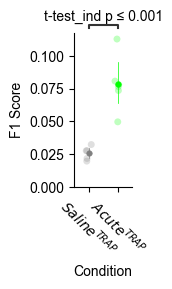

In [306]:
from statannotations.Annotator import Annotator
pannel_key = 'Gdash'
pairs = [("AcM-AcM",'Sal-AcM'),]
sub_conditions = ['Sal-AcM',"AcM-AcM"]
plotting_variable = 'F1_Score'

fig,axs = plt.subplots(1,1,figsize = (0.75,2))
tdata = total_df[(total_df.acronym.isin(rejected_acronyms))&(total_df.Condition.isin(['Sal-AcM',"AcM-AcM"]))
&(total_df.Ex_561_Ch1_stitched_newcounts>0)&(total_df.Ex_639_Ch2_stitched_newcounts>0)
    ]
tdata = tdata[['ID','Condition',plotting_variable]].groupby(['ID','Condition']).mean().reset_index()
sns.stripplot(data = tdata,x = 'Condition',y = plotting_variable,\
        order = sub_conditions,ax = axs,palette = ['gray','lime'],alpha = 0.25)
sns.pointplot(data = tdata,x = 'Condition',y = plotting_variable,\
        order = sub_conditions,ax = axs,palette = ['gray','lime'],
markers="o", markersize=4, linestyle="none",linewidth = 0.5)        
sns.despine()
axs.set_ylim(0,)
axs.set_ylabel('F1 Score')
axs.set_xticklabels([Condition_figure_name[1]] + [Condition_figure_name[0]],rotation= -45)

annotator = Annotator(axs, pairs, data=tdata, x='Condition', y=plotting_variable, order=sub_conditions)
annotator.configure(test='t-test_ind', text_format='simple', loc='outside',)
annotator.configure(comparisons_correction="BH", correction_format="replace")
annotator.apply_and_annotate()
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches = 'tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches = 'tight',dpi = 216)

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_45484\1279261943.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data = tdata,x = 'Condition',y = plotting_variable,\
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_45484\1279261943.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data = tdata,x = 'Condition',y = plotting_variable,\
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_45484\1279261943.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(Condition_figure_name,rotation= -45)


AcM-AcM vs. Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:5.937e-03 t=3.579e+00
AcM-AcM vs. AcM-ChM: t-test independent samples with Benjamini-Hochberg correction, P_val:6.425e-01 t=4.773e-01
AcM-AcM vs. AcM-WDM: t-test independent samples with Benjamini-Hochberg correction, P_val:7.456e-03 t=3.343e+00


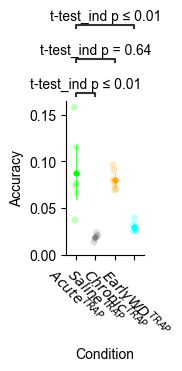

In [307]:
from statannotations.Annotator import Annotator
pannel_key = 'E'
pairs = [("AcM-AcM","AcM-ChM"),("AcM-AcM","AcM-WDM"),("AcM-AcM",'Sal-AcM'),]
plotting_variable = 'overlap_over_Ex_639_Ch2_stitched'

fig,axs = plt.subplots(1,1,figsize = (1,2))
tdata = total_df[(total_df.acronym.isin(rejected_acronyms))
&(total_df.Ex_561_Ch1_stitched_newcounts>0)&(total_df.Ex_639_Ch2_stitched_newcounts>0)
    ]
tdata = tdata[['ID','Condition',plotting_variable]].groupby(['ID','Condition']).mean().reset_index()
sns.stripplot(data = tdata,x = 'Condition',y = plotting_variable,\
        order = Conditions,ax = axs,palette = Condition_color,alpha = 0.25)
sns.pointplot(data = tdata,x = 'Condition',y = plotting_variable,\
        order = Conditions,ax = axs,palette = Condition_color,
markers="o", markersize=4, linestyle="none",linewidth = 0.5)        
sns.despine()
axs.set_ylim(0,)
axs.set_ylabel('Accuracy')
axs.set_xticklabels(Condition_figure_name,rotation= -45)

annotator = Annotator(axs, pairs, data=tdata, x='Condition', y=plotting_variable, order=Conditions)
annotator.configure(test='t-test_ind', text_format='simple', loc='outside',)
annotator.configure(comparisons_correction="BH", correction_format="replace")
annotator.apply_and_annotate()
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches = 'tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches = 'tight',dpi = 216)

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_45484\167856665.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data = tdata,x = 'Condition',y = plotting_variable,\
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_45484\167856665.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data = tdata,x = 'Condition',y = plotting_variable,\
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_45484\167856665.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(Condition_figure_name,rotation= -45)


AcM-AcM vs. Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:1.881e-01 t=1.424e+00
AcM-AcM vs. AcM-ChM: t-test independent samples with Benjamini-Hochberg correction, P_val:3.098e-01 t=-1.065e+00
AcM-AcM vs. AcM-WDM: t-test independent samples with Benjamini-Hochberg correction, P_val:2.429e-04 t=5.553e+00


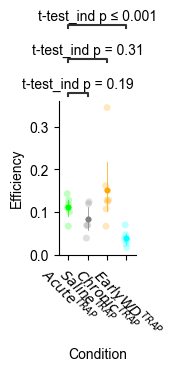

In [308]:
from statannotations.Annotator import Annotator
pannel_key = 'F'
pairs = [("AcM-AcM","AcM-ChM"),("AcM-AcM","AcM-WDM"),("AcM-AcM",'Sal-AcM'),]
plotting_variable = 'overlap_over_Ex_561_Ch1_stitched'

fig,axs = plt.subplots(1,1,figsize = (1,2))
tdata = total_df[(total_df.acronym.isin(rejected_acronyms))
&(total_df.Ex_561_Ch1_stitched_newcounts>5)&(total_df.Ex_639_Ch2_stitched_newcounts>5)
    ]
tdata = tdata[['ID','Condition',plotting_variable]].groupby(['ID','Condition']).mean().reset_index()
sns.stripplot(data = tdata,x = 'Condition',y = plotting_variable,\
        order = Conditions,ax = axs,palette = Condition_color,alpha = 0.25)
sns.pointplot(data = tdata,x = 'Condition',y = plotting_variable,\
        order = Conditions,ax = axs,palette = Condition_color,
markers="o", markersize=4, linestyle="none",linewidth = 0.5)        
sns.despine()
axs.set_ylim(0,)
axs.set_ylabel('Efficiency')
axs.set_xticklabels(Condition_figure_name,rotation= -45)

annotator = Annotator(axs, pairs, data=tdata, x='Condition', y=plotting_variable, order=Conditions)
annotator.configure(test='t-test_ind', text_format='simple', loc='outside',)
annotator.configure(comparisons_correction="BH", correction_format="replace")
annotator.apply_and_annotate()
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches = 'tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches = 'tight',dpi = 216)

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_45484\2270253651.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data = tdata,x = 'Condition',y = plotting_variable,\
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_45484\2270253651.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data = tdata,x = 'Condition',y = plotting_variable,\
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_45484\2270253651.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(Condition_figure_name,rotation= -45)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AcM-AcM vs. Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:3.160e-04 t=5.644e+00
AcM-AcM vs. AcM-ChM: t-test independent samples with Benjamini-Hochberg correction, P_val:3.103e-01 t=-1.064e+00
AcM-AcM vs. AcM-WDM: t-test independent samples with Benjamini-Hochberg correction, P_val:2.370e-04 t=5.571e+00


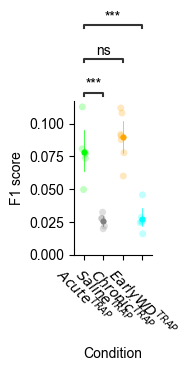

In [309]:
from statannotations.Annotator import Annotator
pannel_key = 'G'
pairs = [("AcM-AcM","AcM-ChM"),("AcM-AcM","AcM-WDM"),("AcM-AcM",'Sal-AcM'),]
plotting_variable = 'F1_Score'

fig,axs = plt.subplots(1,1,figsize = (1,2))
tdata = total_df[(total_df.acronym.isin(rejected_acronyms))
&(total_df.Ex_561_Ch1_stitched_newcounts>0)&(total_df.Ex_639_Ch2_stitched_newcounts>0)
    ]
tdata = tdata[['ID','Condition',plotting_variable]].groupby(['ID','Condition']).mean().reset_index()
sns.stripplot(data = tdata,x = 'Condition',y = plotting_variable,\
        order = Conditions,ax = axs,palette = Condition_color,alpha = 0.25)
sns.pointplot(data = tdata,x = 'Condition',y = plotting_variable,\
        order = Conditions,ax = axs,palette = Condition_color,
markers="o", markersize=4, linestyle="none",linewidth = 0.5)        
sns.despine()
axs.set_ylabel('F1 score')
axs.set_ylim(0,)
axs.set_xticklabels(Condition_figure_name,rotation= -45)

annotator = Annotator(axs, pairs, data=tdata, x='Condition', y=plotting_variable, order=Conditions)
annotator.configure(test='t-test_ind', text_format='star', loc='outside',)
annotator.configure(comparisons_correction="BH", correction_format="replace")
annotator.apply_and_annotate()
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches = 'tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches = 'tight',dpi = 216)

# Figure I

In [23]:
pannel_key = 'I'

Read the clustering results from figure 4. 

In [24]:
embedding_df = pd.read_csv(os.path.join(r"G:\My Drive\Opioid_whole_brain_manuscript\result",f'Figure4E_umap_embedding.csv'),index_col = 0)

In [25]:
# merge the total_df and the embedding dataframe
# all the by region data are stored in one master dataframe
total_df = pd.read_csv(os.path.join(analysis_resultpath,'total_long_merge_Annotated_counts_with_leaf_with_density.csv'),index_col = False)
total_df = total_df[total_df.Condition.isin(Conditions)]
#total_df[total_df.acronym.isin(rejected_acronyms)].acronym.unique().shape
total_df = total_df.merge(embedding_df,left_on  ='acronym',right_on = 'acronym')

In [26]:
# collect the rejected acronyms from Figure 2 analysis
rejected_acronyms = embedding_df.index

In [27]:
plotting_variables

['Ex_561_Ch1_stitched_newcounts',
 'Ex_561_Ch1_stitched_density',
 'Ex_639_Ch2_stitched_newcounts',
 'Ex_639_Ch2_stitched_density',
 'overlap_newcounts',
 'overlap_density',
 'overlap_over_Ex_561_Ch1_stitched',
 'overlap_over_Ex_639_Ch2_stitched',
 'F1_Score']

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_196504\35630459.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels([f"{r+1}" for r in range(len(total_df.label.unique()))],rotation= 0)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

4_AcM-AcM vs. 4_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:2.501e-03 t=4.146e+00
5_AcM-AcM vs. 5_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:1.613e-03 t=4.445e+00
3_AcM-AcM vs. 3_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:6.164e-04 t=5.134e+00
1_AcM-AcM vs. 1_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:1.109e-02 t=3.185e+00
2_AcM-AcM vs. 2_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:2.611e-03 t=4.117e+00
6_AcM-AcM vs. 6_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:5.211e-04 t=5.259e+00
6_AcM-AcM vs. 6_AcM-ChM: t-test independent samples with Benjamini-Hochberg correction, P_val:3.064e-01 t=1.073e

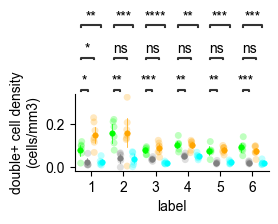

In [29]:
from statannotations.Annotator import Annotator

pairs = [((c,"AcM-AcM"),(c,a)) for c in total_df.label.unique() for a in ["AcM-ChM","AcM-WDM",'Sal-AcM']]
plotting_variable = 'F1_Score'

fig,axs = plt.subplots(1,1,figsize = (2.5,1))
tdata = total_df[(total_df.acronym.isin(rejected_acronyms))
&(total_df.Ex_561_Ch1_stitched_newcounts>0)&(total_df.Ex_639_Ch2_stitched_newcounts>0)
    ]
tdata = tdata[['ID','Condition','label',plotting_variable]].groupby(['ID','Condition','label']).mean().reset_index()
sns.stripplot(data = tdata,hue = 'Condition',x = 'label',y = plotting_variable,dodge = True,\
        hue_order = Conditions,ax = axs,palette = Condition_color,alpha = 0.25)
sns.pointplot(data = tdata,hue = 'Condition',x = 'label',y = plotting_variable,dodge = .8 - .8/(tdata.label.max()+1),\
        hue_order = Conditions,ax = axs,palette = Condition_color,
markers="o", markersize=4, linestyle="none",linewidth = 0.5)        
sns.despine()
axs.set_ylabel('double+ cell density\n(cells/mm3)')
axs.set_xticklabels([f"{r+1}" for r in range(len(total_df.label.unique()))],rotation= 0)

annotator = Annotator(axs, pairs, data=tdata, hue = 'Condition',x = 'label',y = plotting_variable, hue_order=Conditions)
annotator.configure(test='t-test_ind', text_format='star', loc='outside',comparisons_correction="BH", correction_format="replace")
#annotator.configure()
annotator.apply_and_annotate()
axs.legend_.remove()  # Just in case something tries to sneak in

fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches = 'tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches = 'tight',dpi = 216)

# Figure J

In [30]:
figure_key = 'Figure6'
pannel_key = 'J'

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_196504\3060799840.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(cleaned_sorted_acronyms,rotation= -45)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statannotations\compat.py:926: UserWarning: cannot find group0 of pair in the group tuples: ('FrA', 'AcM-AcM') not in [('A24a (IL)', 'AcM-AcM'), ('A24a (IL)', 'Sal-AcM'), ('A24a (IL)', 'AcM-ChM'), ('A24a (IL)', 'AcM-WDM'), ('Au1', 'AcM-AcM'), ('Au1', 'Sal-AcM'), ('Au1', 'AcM-ChM'), ('Au1', 'AcM-WDM'), ('RLi ', 'AcM-AcM'), ('RLi ', 'Sal-AcM'), ('RLi ', 'AcM-ChM'), ('RLi ', 'AcM-WDM'), ('PrEW', 'AcM-AcM'), ('PrEW', 'Sal-AcM'), ('PrEW', 'AcM-ChM'), ('PrEW', 'AcM-WDM'), ('A24 (Cg)', 'AcM-AcM'), ('A24 (Cg)', 'Sal-AcM'), ('A24 (Cg)', 'AcM-ChM'), ('A24 (Cg)', 'AcM-WDM'), ('Cl', 'AcM-AcM'), ('Cl', 'Sal-AcM'), ('Cl', 'AcM-ChM'), ('Cl', 'AcM-WDM'), ('A32 (PrL)', 'AcM-AcM')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

A24 (Cg)_AcM-AcM vs. A24 (Cg)_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:1.912e-03 t=4.327e+00
PrEW_AcM-AcM vs. PrEW_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:6.832e-01 t=4.216e-01
RLi _AcM-AcM vs. RLi _Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:1.291e-01 t=1.671e+00
A24a (IL)_AcM-AcM vs. A24a (IL)_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:3.224e-03 t=3.976e+00
Au1_AcM-AcM vs. Au1_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:1.562e-02 t=2.973e+00
A32 (PrL)_AcM-AcM vs. A32 (PrL)_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:4.542e-04 t=5.364e+00
Cl_AcM-AcM vs. Cl_Sal-AcM: t-test independent samp

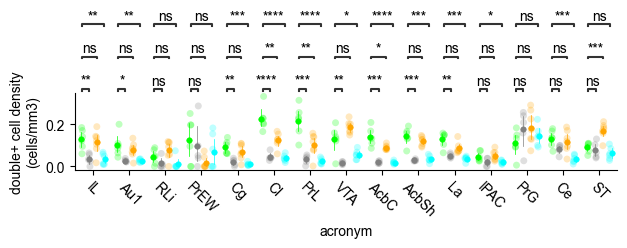

In [31]:
sorted_acronyms =  ['A24a (IL)','Au1','RLi ','PrEW','A24 (Cg)','Cl', 'A32 (PrL)',   'VTA', 'AcbC', 'AcbSh',
       'La','IPAC','PrG','Ce', 'ST', ]
plotting_variable = 'F1_Score'
cleaned_sorted_acronyms = atlas_df.set_index('acronym').loc[sorted_acronyms,'cleaned_acronym'].values

tdata = total_df[(total_df.acronym.isin(rejected_acronyms))]

pairs = [((c,"AcM-AcM"),(c,a)) for c in tdata.acronym.unique() for a in ["AcM-ChM","AcM-WDM",'Sal-AcM']]

fig,axs = plt.subplots(1,1,figsize = (len(tdata.acronym.unique())//12,1))

sns.stripplot(data = tdata,hue = 'Condition',x = 'acronym',y = plotting_variable,dodge = True,order = sorted_acronyms,\
        hue_order = Conditions,ax = axs,palette = Condition_color,alpha = 0.25)
sns.pointplot(data = tdata,hue = 'Condition',x = 'acronym',y = plotting_variable,dodge = .8 - .8/(tdata.label.max()+1),\
        hue_order = Conditions,ax = axs,palette = Condition_color,order = sorted_acronyms,
markers="o", markersize=4, linestyle="none",linewidth = 0.5)        
sns.despine()
axs.set_ylabel('double+ cell density\n(cells/mm3)')
axs.set_xticklabels(cleaned_sorted_acronyms,rotation= -45)

annotator = Annotator(axs, pairs, data=tdata, hue = 'Condition',x = 'acronym',
                        y = plotting_variable, hue_order=Conditions,order = sorted_acronyms,)
annotator.configure(test='t-test_ind', text_format='star', loc='outside',)
annotator.configure(comparisons_correction="BH", correction_format="replace")
annotator.apply_and_annotate()
axs.legend_.remove()  # Just in case something tries to sneak in

fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches = 'tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches = 'tight',dpi = 216)

# Figure 5-supplemental figure 1

In [249]:
figure_key = 'Figure6-supplemental figure 1'
pannel_key = 'A'

In [254]:
embedding_df = pd.read_csv(os.path.join(r"G:\My Drive\Opioid_whole_brain_manuscript\result",f'Figure4E_umap_embedding.csv'),index_col = 0)

In [255]:
# merge the total_df and the embedding dataframe
# all the by region data are stored in one master dataframe
total_df = pd.read_csv(os.path.join(analysis_resultpath,'total_long_merge_Annotated_counts_with_leaf_with_density.csv'),index_col = False)
total_df = total_df[total_df.Condition.isin(Conditions)]
#total_df[total_df.acronym.isin(rejected_acronyms)].acronym.unique().shape
total_df = total_df.merge(embedding_df,left_on  ='acronym',right_on = 'acronym')

In [256]:
# collect the rejected acronyms from Figure 2 analysis
rejected_acronyms = embedding_df.index

In [253]:
# merge the total_df and the embedding dataframe
# all the by region data are stored in one master dataframe
total_df = pd.read_csv(os.path.join(analysis_resultpath,'total_long_merge_Annotated_counts_with_leaf_with_density.csv'),index_col = False)
total_df = total_df[total_df.Condition.isin(Conditions)]

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_45484\2146619539.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cleaned_sorted_acronyms[region_slice],rotation= -45)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DI_AcM-AcM vs. DI_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:5.863e-04 t=5.171e+00
MEnt_AcM-AcM vs. MEnt_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:2.579e-03 t=4.125e+00
PrEW_AcM-AcM vs. PrEW_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:6.832e-01 t=4.216e-01
CPre_AcM-AcM vs. CPre_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:1.395e-03 t=4.545e+00
MD_AcM-AcM vs. MD_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:6.736e-04 t=5.068e+00
A32 (PrL)_AcM-AcM vs. A32 (PrL)_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:4.542e-04 t=5.364e+00
PIL_AcM-AcM vs. PIL_Sal-AcM: t-test independent samples with Benjamini-Hoc

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_45484\2146619539.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cleaned_sorted_acronyms[region_slice],rotation= -45)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PoMn_AcM-AcM vs. PoMn_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:3.773e-01 t=9.287e-01
Po_AcM-AcM vs. Po_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:3.910e-01 t=9.011e-01
AM_AcM-AcM vs. AM_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:5.200e-03 t=3.664e+00
A24 (Cg)_AcM-AcM vs. A24 (Cg)_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:1.912e-03 t=4.327e+00
PC_AcM-AcM vs. PC_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:6.799e-03 t=3.493e+00
IP_AcM-AcM vs. IP_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:8.573e-02 t=1.930e+00
O_AcM-AcM vs. O_Sal-AcM: t-test independent samples with Benjamini-Hochberg correcti

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_45484\2146619539.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cleaned_sorted_acronyms[region_slice],rotation= -45)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tu_AcM-AcM vs. Tu_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:5.452e-02 t=2.209e+00
MG_AcM-AcM vs. MG_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:2.414e-01 t=1.254e+00
IPAC_AcM-AcM vs. IPAC_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:5.615e-02 t=2.191e+00
RLi _AcM-AcM vs. RLi _Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:1.291e-01 t=1.671e+00
PLi_AcM-AcM vs. PLi_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:1.766e-01 t=1.466e+00
CM_AcM-AcM vs. CM_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:6.444e-03 t=3.527e+00
AuD_AcM-AcM vs. AuD_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_45484\2146619539.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cleaned_sorted_acronyms[region_slice],rotation= -45)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Com_AcM-AcM vs. Com_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:nan t=nan
PlPAG_AcM-AcM vs. PlPAG_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:nan t=nan
Pa4_AcM-AcM vs. Pa4_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:2.967e-01 t=-1.108e+00
Sc_AcM-AcM vs. Sc_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:2.967e-01 t=-1.108e+00
VTg_AcM-AcM vs. VTg_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:nan t=nan
FrA_AcM-AcM vs. FrA_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:1.188e-02 (ns) t=3.143e+00
CA2_AcM-AcM vs. CA2_Sal-AcM: t-test independent samples with Benjamini-Hochberg correction, P_val:1.891e-02 (ns) t=

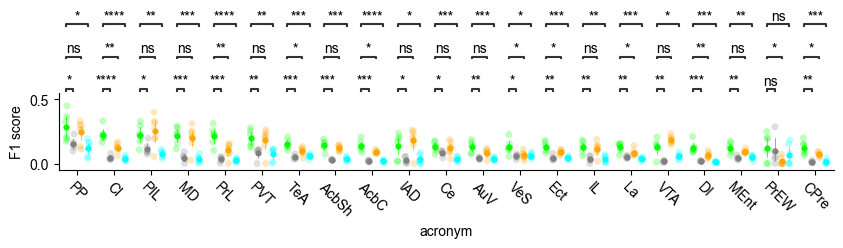

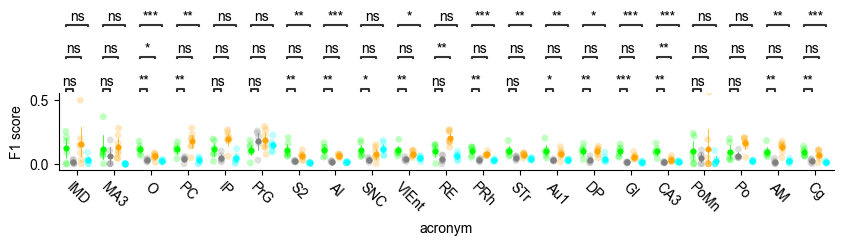

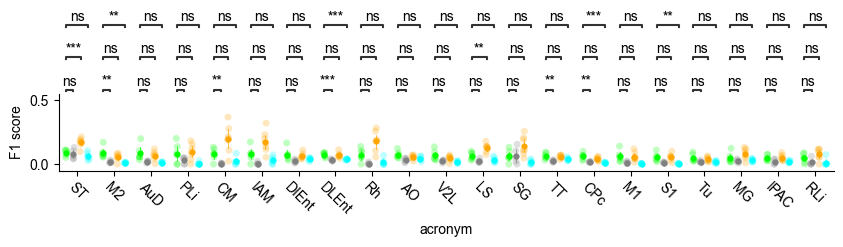

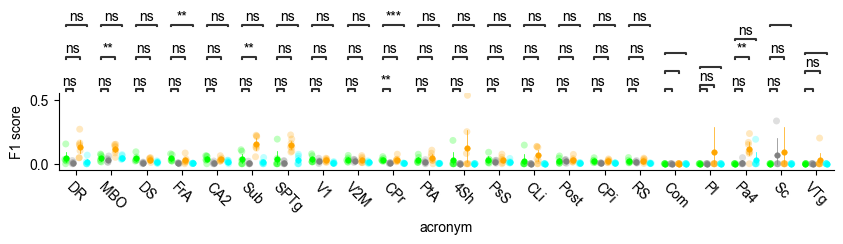

In [260]:
from statannotations.Annotator import Annotator

plotting_variable = 'F1_Score'
tdata = total_df[(total_df.acronym.isin(rejected_acronyms))]
sorted_acronyms = tdata.loc[tdata.Condition == Conditions[0],['acronym',plotting_variable]].groupby(['acronym']).mean().sort_values(by=plotting_variable,ascending = False).index
cleaned_sorted_acronyms = atlas_df.set_index('acronym').loc[sorted_acronyms,'cleaned_acronym']

for idx in range(4):
        fig,ax = plt.subplots(1,1,figsize = (len(rejected_acronyms)//8,1),sharey = True)

        region_slice = slice(idx*len(sorted_acronyms)//4,((idx+1)*len(sorted_acronyms)//4))
        pairs = [((a,"AcM-AcM"),(a,"AcM-ChM")) for a in sorted_acronyms[region_slice]]+\
        [((a,"AcM-AcM"),(a,"AcM-WDM")) for a in sorted_acronyms[region_slice]]+\
        [((a,"AcM-AcM"),(a,'Sal-AcM')) for a in sorted_acronyms[region_slice]]
        sns.stripplot(data = tdata[tdata.acronym.isin(sorted_acronyms[region_slice])],hue = 'Condition',x = 'acronym',y = plotting_variable,
                      order = sorted_acronyms[region_slice],\
                hue_order = Conditions,ax = ax,palette = Condition_color,alpha = 0.25,dodge = True)
        sns.pointplot(data = tdata[tdata.acronym.isin(sorted_acronyms[region_slice])],hue = 'Condition',x = 'acronym',y = plotting_variable,dodge = .8 - .8 / len(Conditions),\
                hue_order = Conditions,ax = ax,palette = Condition_color,
                order = sorted_acronyms[region_slice],
        markers="o", markersize=4, linestyle="none",linewidth = 0.5)        
        sns.despine()
        # remove legend
        ax.get_legend().remove()
        ax.set_ylim(-0.05,0.55)
        ax.set_ylabel('F1 score')
        ax.set_xticklabels(cleaned_sorted_acronyms[region_slice],rotation= -45)
        annotator = Annotator(ax, pairs, data=tdata[tdata.acronym.isin(sorted_acronyms[region_slice])],
                               x = 'acronym',hue='Condition', y=plotting_variable,order = sorted_acronyms[region_slice], hue_order=Conditions)
        annotator.configure(test='t-test_ind', text_format='star', loc='outside',)
        annotator.configure(comparisons_correction="BH", correction_format="replace")
        annotator.apply_and_annotate()
        #fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{idx}.png'),bbox_inches = 'tight',dpi = 216)
        #fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{idx}.pdf'),bbox_inches = 'tight',dpi = 216)

# Figure H

In [ ]:
pannel_key = 'H'

In [ ]:
channel = 'overlap'
# pre selected zplanes
curated_zplanes = [84,104,117,153,186,220]

In [ ]:
import numpy as np

def set_transparency(rgba_img, mask):
    """
    Applies a transparency mask to an existing RGBA image.

    Parameters:
    - rgba_img: np.ndarray of shape (H, W, 4), dtype uint8
        The input RGBA image.
    - mask: np.ndarray of shape (H, W), dtype bool
        Boolean mask where True means the pixel should be transparent.

    Returns:
    - np.ndarray of shape (H, W, 4), modified RGBA image.
    """
    if rgba_img.shape[-1] != 4:
        raise ValueError("Input image must be RGBA (shape must be H x W x 4).")
    if rgba_img.shape[:2] != mask.shape:
        raise ValueError("Mask shape must match image height and width.")

    # Copy to avoid modifying the original
    result = rgba_img.copy()
    result[mask, 3] = 0  # Set alpha to 0 (transparent) where mask is True
    return result


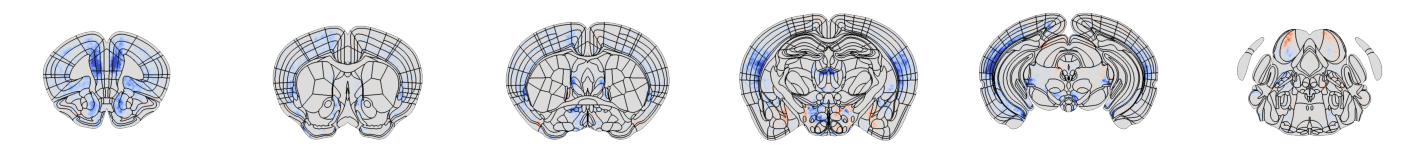

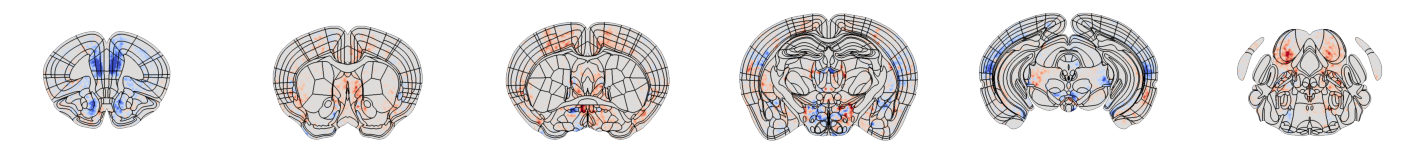

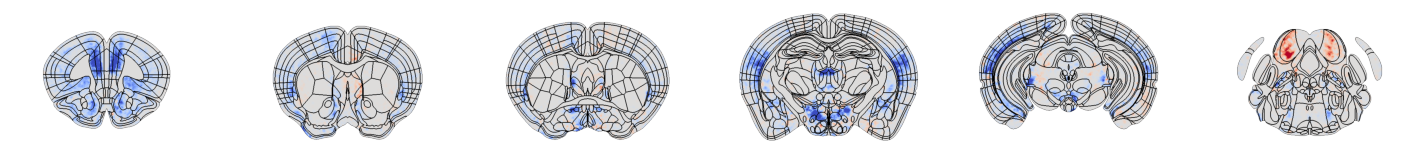

In [ ]:
# plot every 10 zplanes
# slice for visualization
imy_slice = slice(25,425)
imx_slice = slice(50,600)
for condition in Conditions[1:]:
    theatmap = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\OPTRAP\result",\
                                    f'{channel}_{condition}_betas.npy'))

    fig,axs = plt.subplots(1,len(curated_zplanes),figsize = (3*len(curated_zplanes),3),sharey = True)
    fig.subplots_adjust(wspace=0.25, hspace=0.3)

    for idx,ax in enumerate(axs):
        formatted_idx = f"{curated_zplanes[idx]:04}" 
        
        __,overlayed_image = overlap_contour(theatmap,contour_img,\
        cmin =  -5, cmax = 5,\
        outputpath = None,colormap = plt.cm.coolwarm)
        trans_img = set_transparency(overlayed_image[curated_zplanes[idx],:,:], (atlas_img==0)[curated_zplanes[idx],:,:])
        ax.imshow(trans_img[imy_slice,imx_slice])
        ax.axis('off')
        ax.set_title('')
        ax.set_ylabel(condition,color = 'black')
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{condition}_betacoef.png'),bbox_inches='tight',dpi = 1024)
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{condition}_betacoef.pdf'),bbox_inches='tight',dpi = 1024)

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\dask\array\core.py:1721: FutureWarning: The `numpy.min_scalar_type` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0

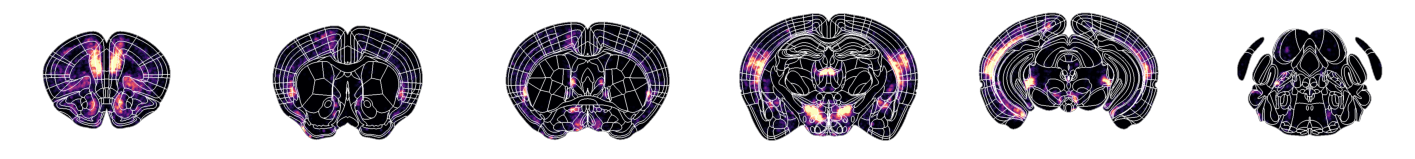

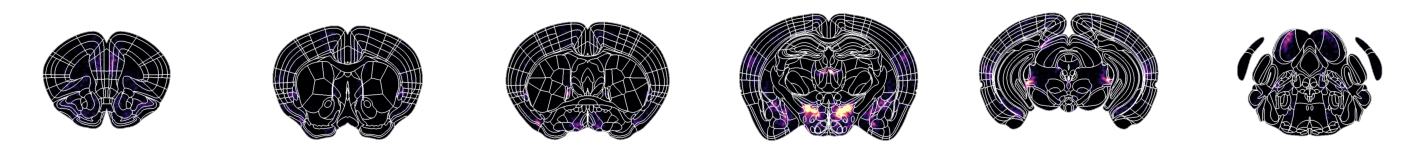

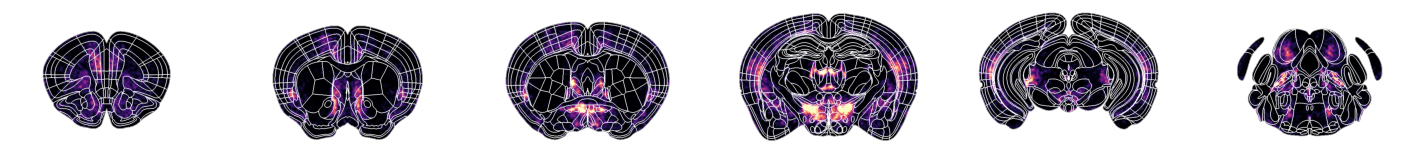

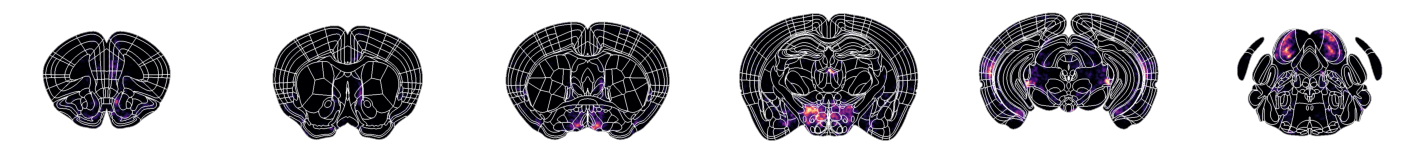

In [ ]:
import contour_visualization2 as cv2
# plot every 10 zplanes
# slice for visualization
imy_slice = slice(25,425)
imx_slice = slice(50,600)
condition = Conditions[0]
for condition in Conditions:
    theatmap = np.mean(heatmap_dict['overlap'][metadf.Condition == condition,:],axis = 0).reshape(atlas_img.shape)

    fig,axs = plt.subplots(1,len(curated_zplanes),figsize = (3*len(curated_zplanes),3),sharey = True)
    fig.subplots_adjust(wspace=0.25, hspace=0.3)

    for idx,ax in enumerate(axs):
        formatted_idx = f"{curated_zplanes[idx]:04}" 
        
        __,overlayed_image = cv2.overlap_contour(theatmap,contour_img,\
        cmin =  0, cmax = 5,\
        outputpath = None,colormap = plt.cm.magma)
        trans_img = set_transparency(overlayed_image[curated_zplanes[idx],:,:], (atlas_img==0)[curated_zplanes[idx],:,:])
        ax.imshow(trans_img[imy_slice,imx_slice])
        ax.axis('off')
        ax.set_title('')
        ax.set_ylabel(condition,color = 'black')
    #fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{condition}_mean.png'),bbox_inches='tight',dpi = 1024)
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{condition}_mean.svg'),bbox_inches='tight',dpi = 1024)

# Figure K-M

spatial analysis by subregions

### Acb

In [ ]:
pannel_key = 'K'

In [ ]:
# target site can be experiment specific
target_site_acronym = 'Acb'
target_site_id = atlas_df.loc[atlas_df.acronym == target_site_acronym,'id'].values[0]
target_site_subids = create_mask_for_region.get_subregions(atlas_df,target_site_id,return_original=True)['id'].values


In [ ]:
# collect all the z positions where there is the target site
zs = np.array([])
for ID in target_site_subids:
    z_,y_,x_ = np.where(atlas_img == ID)
    zs = np.concatenate([zs,z_])
# find the center of mass of the OFC
z_unique = np.unique(zs).astype('uint16')
z_center = int(np.mean(zs))


In [ ]:
# subset to NAc region
xslice = slice(325,325+120)
yslice = slice(240,240+120)

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\dask\array\core.py:1721: FutureWarning: The `numpy.min_scalar_type` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0

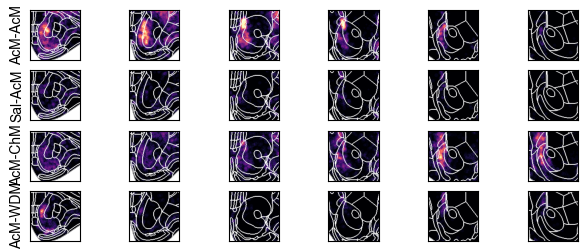

In [ ]:
# plot the spatial distribution of double+ cells for each subject

fig, axs = plt.subplots(len(Conditions), len(z_unique[::5]), figsize=(len(z_unique[::5])*1.25, len(Conditions)-1), sharex=True,sharey = True)


for cidx, condition in enumerate(Conditions):
    theatmap = np.mean(heatmap_dict['overlap'][metadf.Condition == condition,:],axis = 0).reshape(atlas_img.shape)

    #theatmap = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'{condition}_betas.npy'))
    #theatmap = np.mean(np.array([heatmap_dict[condition][subject] for subject in heatmap_dict[condition].keys()]),axis = 0)
    __,overlayed_image = cv2.overlap_contour(theatmap,contour_img,\
        cmin =  -0, cmax = 5,\
        outputpath = None,colormap = plt.cm.magma)
    for idx, curated_zplane in enumerate(z_unique[::5]):
        ax = axs[cidx, idx]
        trans_img = set_transparency(overlayed_image[curated_zplane,:,:], (atlas_img==0)[curated_zplane,:,:])
        ax.imshow(trans_img[yslice,xslice])
        #ax.imshow(overlayed_image[curated_zplane,yslice,xslice],cmap = 'viridis')
        ax.set_xticks([])  # Remove x ticks
        ax.set_yticks([])  # Remove y ticks
        #ax.axis('off')
        if idx == 0:
            ax.set_ylabel(condition, color='black', )
        else:
            ax.set_ylabel('', color='black',)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches='tight',dpi = 1024)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.svg'),bbox_inches='tight',dpi = 1024)

In [ ]:
pannel_key = 'L'

In [ ]:
# calculate the spatial distribution of c-Fos+ cells for each subject
for condition in Conditions:
    subjects = metadf[metadf.Condition == condition].ID # get the list of subjects from the meta dataframe
    spatial_cell_count_for_target = []
    
    for sidx,subject in enumerate(subjects):
        # get the average density of starter cells in VTA for each z position
        #subset_heatmap = heatmap_dict[condition][subject]
        subset_heatmap = np.reshape(heatmap_dict[channel_key][metadf.ID == subject,:],atlas_img.shape).compute()
        # calculate the cell count by z potision for all VTA subregions
        spatial_cell_count_for_subregion = np.array([[np.nanmean(subset_heatmap[z,:,:][np.where(atlas_img[z,:,:]\
             == target_site_subid)]) for z in z_unique] for target_site_subid in target_site_subids])
        # append spatial_cell_count_for_subregion
        if sidx == 0:
            spatial_cell_count_for_subregion_sum = [spatial_cell_count_for_subregion]
        else:
            spatial_cell_count_for_subregion_sum = np.concatenate([spatial_cell_count_for_subregion_sum,[spatial_cell_count_for_subregion]], axis = 0)
        # sum the cell count by z position for the entire VTA
        spatial_cell_count_for_full = np.nansum(spatial_cell_count_for_subregion,axis = 0)
        spatial_cell_count_for_target.append(spatial_cell_count_for_full)

    spatial_cell_count_for_target = pd.DataFrame(spatial_cell_count_for_target,index = subjects, columns = z_unique)
    
    # write the result
    spatial_cell_count_for_target.to_csv(os.path.join(analysis_resultpath,f'{condition}_spatial_distribution_of_starter_cells_in_{target_site_acronym}.csv'))
    np.save(os.path.join(analysis_resultpath,f'{condition}_spatial_cell_count_for_subregion_sum_{target_site_acronym}.npy'),
    spatial_cell_count_for_subregion_sum,)

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


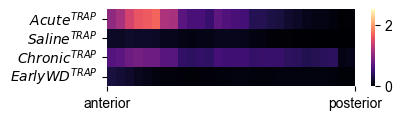

In [ ]:
pannel_key = 'L'
tidx = 0
target_site_subid = target_site_subids[tidx]
#print(target_site_subid)
target_site_subacronym = atlas_df[atlas_df['id'] == target_site_subid].acronym.values[0]
t = []
for condition in Conditions:
    #print(condition)
    spatial_cell_count_for_subregion_sum = np.load(os.path.join(analysis_resultpath,f'{condition}_spatial_cell_count_for_subregion_sum_{target_site_acronym}.npy'),)
    t.append(np.nanmean(spatial_cell_count_for_subregion_sum[:,tidx],axis = 0))
fig,axs = plt.subplots(1,1,figsize= (4,1))
sns.heatmap(pd.DataFrame(t).fillna(0),vmin = 0,vmax = 2.5,cmap = plt.cm.magma)
axs.set_yticklabels(Condition_figure_name,rotation = 0)
axs.set_xticks([0,len(z_unique)])
axs.set_xticklabels(['anterior','posterior'])

fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_.png'),bbox_inches='tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches='tight',dpi = 216)

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_27048\1545618341.py:11: RuntimeWarning: Mean of empty slice
  t.append(np.nanmean(spatial_cell_count_for_subregion_sum[:,tidx],axis = 0))


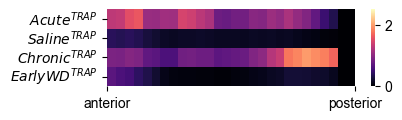

In [ ]:
pannel_key = 'M'
tidx = 1
target_site_subid = target_site_subids[tidx]

#print(target_site_subid)
target_site_subacronym = atlas_df[atlas_df['id'] == target_site_subid].acronym.values[0]
t = []
for condition in Conditions:
    #print(condition)
    spatial_cell_count_for_subregion_sum = np.load(os.path.join(analysis_resultpath,f'{condition}_spatial_cell_count_for_subregion_sum_{target_site_acronym}.npy'),)
    t.append(np.nanmean(spatial_cell_count_for_subregion_sum[:,tidx],axis = 0))
fig,axs = plt.subplots(1,1,figsize= (4,1))
sns.heatmap(pd.DataFrame(t).fillna(0),vmin = 0,vmax = 2.5,cmap = plt.cm.magma)
axs.set_yticklabels(Condition_figure_name,rotation = 0)
axs.set_xticks([0,len(z_unique)])
axs.set_xticklabels(['anterior','posterior'])

fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_.png'),bbox_inches='tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches='tight',dpi = 216)